Import packages

In [554]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, plot, iplot
import sqlite3
import Code.Preparation as prep
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import re
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

### Clean and combine happiness reports dataset

Load datasets

In [187]:
df2015 = pd.read_csv(prep.path('happy/2015.csv'))
df2015['Year'] = (2015)
df2016 = pd.read_csv(prep.path('happy/2016.csv'))
df2016['Year'] = 2016
df2017 = pd.read_csv(prep.path('happy/2017.csv'))
df2017['Year'] = 2017
df2018 = pd.read_csv(prep.path('happy/2018.csv'))
df2018['Year'] = 2018
df2019 = pd.read_csv(prep.path('happy/2019.csv'))
df2019['Year'] = 2019

In [266]:
happydf = pd.merge(df2015, df2016, how='outer').merge(df2017, how='outer').merge(df2018, how='outer').merge(df2019, how='outer')

In [267]:
happydf.Country = happydf.Country.fillna(happydf['Country or region'])
happydf['Happiness Rank'] = happydf['Happiness Rank'].fillna(happydf['Happiness.Rank'])
happydf['Happiness Rank'] = happydf['Happiness Rank'].fillna(happydf['Overall rank'])
happydf['Happiness Score'] = happydf['Happiness Score'].fillna(happydf['Happiness.Score'])
happydf['Happiness Score'] = happydf['Happiness Score'].fillna(happydf['Score'])
happydf['Economy (GDP per Capita)'] = happydf['Economy (GDP per Capita)'].fillna(happydf['Economy..GDP.per.Capita.'])
happydf['Economy (GDP per Capita)'] = happydf['Economy (GDP per Capita)'].fillna(happydf['GDP per capita'])
happydf['Health (Life Expectancy)'] = happydf['Health (Life Expectancy)'].fillna(happydf['Health..Life.Expectancy.'])
happydf['Health (Life Expectancy)'] = happydf['Health (Life Expectancy)'].fillna(happydf['Healthy life expectancy'])
happydf['Trust (Government Corruption)'] = happydf['Trust (Government Corruption)'].fillna(happydf['Perceptions of corruption'])
happydf['Trust (Government Corruption)'] = happydf['Trust (Government Corruption)'].fillna(happydf['Trust..Government.Corruption.'])
happydf['Freedom'] = happydf['Freedom'].fillna(happydf['Freedom to make life choices'])
happydf['Social support'] = happydf['Social support'].fillna(happydf['Family'])
happydf = pd.DataFrame(happydf[['Country', 'Year', 'Happiness Rank', 'Happiness Score', 'Economy (GDP per Capita)', 'Social support', 'Trust (Government Corruption)', 'Generosity']])

In [268]:
happydf.dropna(inplace=True)
happydf['Year'] = happydf['Year'].astype(str)
happydf['Year'] = pd.to_datetime(happydf['Year'])
# happydf = happydf.set_index(['Country', 'Year'])

In [191]:
happydf.to_csv('Data/CleanedHappy.csv')

In [563]:
ratedf = pd.read_csv(prep.path('sucide.csv'))
ratedf = ratedf.rename(columns = {'country':'Country', 'year':'Year'})
ratedf['Year'] = ratedf['Year'].astype(str)
ratedf['Year'] = pd.to_datetime(ratedf['Year'])
ratedf = ratedf.drop(columns=['country-year'])
ratedf.dropna(inplace=True)
# ratedf.set_index(['Country', 'Year'], inplace=True)
ratedf.drop(columns=[' gdp_for_year ($) '], inplace=True)
ratedf = pd.get_dummies(ratedf, prefix=['sex', 'age', 'generation'], columns=['sex', 'age', 'generation'])

In [564]:
ratedf.to_csv('Data/Ratedf.csv')

In [37]:
ratedf.to_csv('Data/CleanedSuicide.csv')

In [535]:
datadf = pd.read_csv(prep.path('WDI/WDIData.csv'))
countrydf = pd.read_csv(prep.path('WDI/WDICountry.csv'))
df = pd.read_csv(prep.path('World_Development/Indicators.csv'))

In [536]:
Indicator_array =  df[['IndicatorName','IndicatorCode']].drop_duplicates().values

In [537]:
modified_indicators = []
unique_indicator_codes = []
for ele in Indicator_array:
    indicator = ele[0]
    indicator_code = ele[1].strip()
    if indicator_code not in unique_indicator_codes:
        # delete , ( ) from the IndicatorNames
        new_indicator = re.sub('[,()]',"",indicator).lower()
        # replace - with "to" and make all words into lower case
        new_indicator = re.sub('-'," to ",new_indicator).lower()
        modified_indicators.append([new_indicator,indicator_code])
        unique_indicator_codes.append(indicator_code)

Indicators = pd.DataFrame(modified_indicators,columns=['IndicatorName','IndicatorCode'])
Indicators = Indicators.drop_duplicates()
print(Indicators.shape)

(1344, 2)


In [538]:
key_word_dict = {}
key_word_dict['Demography'] = ['population','birth','death','fertility','mortality','expectancy']
key_word_dict['Food'] = ['food','grain','nutrition','calories']
key_word_dict['Trade'] = ['trade','import','export','good','shipping','shipment']
key_word_dict['Health'] = ['health','desease','hospital','mortality','doctor']
key_word_dict['Economy'] = ['income','gdp','gni','deficit','budget','market','stock','bond','infrastructure']
key_word_dict['Energy'] = ['fuel','energy','power','emission','electric','electricity']
key_word_dict['Education'] = ['education','literacy']
key_word_dict['Employment'] =['employed','employment','umemployed','unemployment']
key_word_dict['Rural'] = ['rural','village']
key_word_dict['Urban'] = ['urban','city']
key_word_dict['Social Programs'] = ['social']

In [539]:
feature = 'Social Programs'
for indicator_ele in Indicators.values:
    for ele in key_word_dict[feature]:
        word_list = indicator_ele[0].split()
        if ele in word_list or ele+'s' in word_list:
            # Uncomment this line to print the indicators explicitely
            print(indicator_ele)
            break

['social contributions % of revenue' 'GC.REV.SOCL.ZS']
['social contributions current lcu' 'GC.REV.SOCL.CN']
['adequacy of social insurance programs % of total welfare of beneficiary households'
 'per_si_allsi.adq_pop_tot']
['adequacy of social protection and labor programs % of total welfare of beneficiary households'
 'per_allsp.adq_pop_tot']
['benefits incidence in poorest quintile %  to  all social insurance'
 'per_si_allsi.ben_q1_tot']
['benefits incidence in poorest quintile %  to all social protection and labor'
 'per_allsp.ben_q1_tot']
['coverage %  to  all social insurance' 'per_si_allsi.cov_pop_tot']
['coverage %  to all social protection and labor' 'per_allsp.cov_pop_tot']
['coverage %  to  all social assistance' 'per_sa_allsa.cov_pop_tot']
['adequacy of social safety net programs % of total welfare of beneficiary households'
 'per_sa_allsa.adq_pop_tot']
['benefits incidence in poorest quintile %  to  all social assistance'
 'per_sa_allsa.ben_q1_tot']
['cpia policies for soc

In [555]:
# Main indicators to compare contries
chosen_indicators = ['GC.REV.SOCL.ZS',  \
                     'GC.REV.SOCL.CN', 'IQ.CPA.PROT.XQ', 'IQ.CPA.SOCI.XQ']

# Subset of data with the required features alone
df_subset = df[df['IndicatorCode'].isin(chosen_indicators)]

# Chose only India and China for Analysis
df_Arg = df_subset[df['CountryName']=="Argentina"]
df_usa = df_subset[df['CountryName']=="United States"]

# PLotting function for comparing development indicators
def plot_indicator(indicator,delta=10):
    ds_Arg = df_Arg[['IndicatorName','Year','Value']][df_Arg['IndicatorCode']==indicator]
    try:
        title = ds_Arg['IndicatorName'].iloc[5]
    except:
        title = "None"

    xArg = ds_Arg['Year'].values
    yArg = ds_Arg['Value'].values
    ds_usa = df_usa[['IndicatorName','Year','Value']][df_usa['IndicatorCode']==indicator]
    xusa = ds_usa['Year'].values
    yusa = ds_usa['Value'].values
    
    plt.figure(figsize=(14,4))
    
    plt.subplot(121)
    plt.plot(xArg,yArg,label='Argentina')
    plt.plot(xusa,yusa,label='USA')
    plt.title(title)
    plt.legend(loc=2)

    plt.subplot(122)
    plt.plot(xArg,yArg,label='Argentina')
    plt.plot(xusa+delta,yusa,label='USA')
    plt.title(title + "\n USA Data Shifted by " +str(delta)+" Years")
    plt.legend(loc=2)

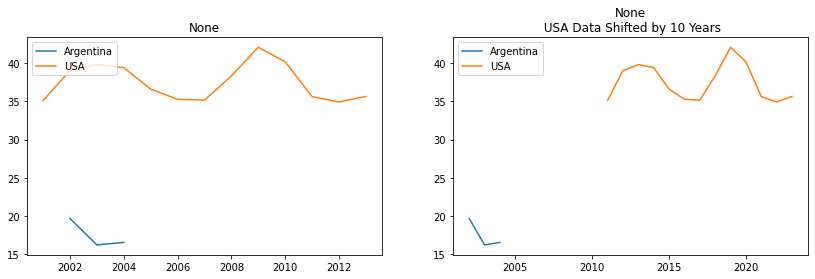

In [556]:
plot_indicator(chosen_indicators[0],delta=10)

In [15]:
datadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422136 entries, 0 to 422135
Data columns (total 64 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Country Name    422136 non-null  object 
 1   Country Code    422136 non-null  object 
 2   Indicator Name  422136 non-null  object 
 3   Indicator Code  422136 non-null  object 
 4   1960            38296 non-null   float64
 5   1961            42017 non-null   float64
 6   1962            44198 non-null   float64
 7   1963            44084 non-null   float64
 8   1964            44611 non-null   float64
 9   1965            47305 non-null   float64
 10  1966            46902 non-null   float64
 11  1967            48633 non-null   float64
 12  1968            48209 non-null   float64
 13  1969            50011 non-null   float64
 14  1970            92892 non-null   float64
 15  1971            99126 non-null   float64
 16  1972            101898 non-null  float64
 17  1973      

In [490]:
worlddf = pd.DataFrame(datadf.groupby(['Country Name','Indicator Name']).mean().stack())
worlddf = worlddf.reset_index()
worlddf = worlddf.rename(columns={0: 'Value', 'level_2': 'Year', 'Country Name': 'Country', 'Indicator Name': 'IndicatorName'})
worlddf['Year'] = worlddf['Year'].astype(str)
worlddf['Year'] = pd.to_datetime(worlddf['Year'])

In [491]:
worlddf = worlddf[(worlddf.IndicatorName == 'Imports of goods and services (annual % growth)')| 
        (worlddf.IndicatorName == 'Imports of goods and services (% of GDP)')| 
        (worlddf.IndicatorName == 'High-technology exports (% of manufactured exports)')| 
        (worlddf.IndicatorName == 'Cost to import (US$ per container)')| 
        (worlddf.IndicatorName == 'Cost to export (US$ per container)')| 
        (worlddf.IndicatorName == 'Food imports (% of merchandise imports)')| 
        (worlddf.IndicatorName == 'Food exports (% of merchandise exports)')| 
        (worlddf.IndicatorName == 'Exports of goods and services (annual % growth)')|
        (worlddf.IndicatorName == 'Exports of goods and services (% of GDP)')| 
        (worlddf.IndicatorName == 'Out-of-school children of primary school age, both sexes (number)')|
        (worlddf.IndicatorName == 'Enrolment in secondary vocational, both sexes (number)')| 
        (worlddf.IndicatorName == 'Enrolment in secondary general, both sexes (number)')|
        (worlddf.IndicatorName == 'Enrolment in secondary education, both sexes (number)')|
        (worlddf.IndicatorName == 'Enrolment in primary education, both sexes (number)')|
        (worlddf.IndicatorName == 'Labor force with tertiary education (% of total)')|
        (worlddf.IndicatorName == 'Labor force with secondary education (% of total)')|
        (worlddf.IndicatorName == 'Labor force with primary education (% of total)')|
        (worlddf.IndicatorName == 'Labor force participation rate, total (% of total population ages 15+) (national estimate)')|
        (worlddf.IndicatorName == 'Employers, total (% of employment)')|
        (worlddf.IndicatorName == 'Annualized average growth rate in per capita real survey mean consumption or income, total population (%)')|
        (worlddf.IndicatorName == 'Annualized average growth rate in per capita real survey mean consumption or income, bottom 40% of population (%)')|
        (worlddf.IndicatorName == 'Adjusted net national income per capita (annual % growth)')|
        (worlddf.IndicatorName == 'Antiretroviral therapy coverage (% of people living with HIV)')|
        (worlddf.IndicatorName == 'Adequacy of unemployment benefits and ALMP (% of total welfare of beneficiary households)')|
        (worlddf.IndicatorName == 'Adequacy of social safety net programs (% of total welfare of beneficiary households)')|
        (worlddf.IndicatorName == 'Adequacy of social protection and labor programs (% of total welfare of beneficiary households)')|
        (worlddf.IndicatorName == 'Adequacy of social insurance programs (% of total welfare of beneficiary households)')|
        (worlddf.IndicatorName == 'Improved water source, urban (% of urban population with access)')|
        (worlddf.IndicatorName == 'Improved water source, rural (% of rural population with access)')|
        (worlddf.IndicatorName == 'Improved water source (% of population with access)')|
        (worlddf.IndicatorName == 'Improved sanitation facilities, urban (% of urban population with access)')|
        (worlddf.IndicatorName == 'Improved sanitation facilities, rural (% of rural population with access)')|
        (worlddf.IndicatorName == 'Improved sanitation facilities (% of population with access)')|
        (worlddf.IndicatorName == 'Mobile cellular subscriptions (per 100 people)')|
        (worlddf.IndicatorName == 'Fixed telephone subscriptions (per 100 people)')|
        (worlddf.IndicatorName == 'Fixed broadband subscriptions (per 100 people)')|
        (worlddf.IndicatorName == 'Depth of the food deficit (kilocalories per person per day)')|
        (worlddf.IndicatorName == 'Access to electricity, urban (% of urban population)')|
        (worlddf.IndicatorName == 'Access to electricity, rural (% of rural population)')|
        (worlddf.IndicatorName == 'Access to electricity (% of population)')|
        (worlddf.IndicatorName == 'Multilateral debt (% of total external debt)')|
        (worlddf.IndicatorName == 'Life expectancy at birth, total (years)')|
        (worlddf.IndicatorName == 'Household final consumption expenditure per capita growth (annual %)')|
        (worlddf.IndicatorName == 'GDP per capita growth (annual %)')|
        (worlddf.IndicatorName == 'GDP growth (annual %)' )|
        (worlddf.IndicatorName == 'GDP per capita (current US$)' )|
        (worlddf.IndicatorName == 'Percentage of enrolment in secondary education in private institutions (%)')|
        (worlddf.IndicatorName == 'Percentage of enrolment in primary education in private institutions (%)')|
        (worlddf.IndicatorName == 'Poverty gap at national poverty lines (%)')|
        (worlddf.IndicatorName == 'Prevalence of undernourishment (% of population)')|
        (worlddf.IndicatorName == 'Rural population (% of total population)')|
        (worlddf.IndicatorName == 'Rural poverty gap at national poverty lines (%)')|
        (worlddf.IndicatorName == 'Urban poverty gap at national poverty lines (%)')|
        (worlddf.IndicatorName == 'Share of youth not in education, employment, or training, total (% of youth population)')|
        (worlddf.IndicatorName == 'Social contributions (% of revenue)')|
        (worlddf.IndicatorName == 'Unemployment, total (% of total labor force) (national estimate)')|
        (worlddf.IndicatorName == 'Unemployment, total (% of total labor force)')|
        (worlddf.IndicatorName == 'Vulnerable employment, total (% of total employment)')]

In [145]:
releventyears = worlddf[worlddf['Year'] >= '2015']

In [82]:
features = ['Access to electricity (% of population)',
            'Access to electricity, rural (% of rural population)',
            'Access to electricity, urban (% of urban population)',
            'Adequacy of social insurance programs (% of total welfare of beneficiary households)',
            'Adequacy of social protection and labor programs (% of total welfare of beneficiary households)',
            'Adequacy of social safety net programs (% of total welfare of beneficiary households)',
            'Adjusted net national income per capita (annual % growth)',
            'Annualized average growth rate in per capita real survey mean consumption or income, bottom 40% of population (%)',
            'Annualized average growth rate in per capita real survey mean consumption or income, total population (%)',
            'Antiretroviral therapy coverage (% of people living with HIV)',
            'Exports of goods and services (% of GDP)',
            'Exports of goods and services (annual % growth)',
            'Fixed broadband subscriptions (per 100 people)',
            'Fixed telephone subscriptions (per 100 people)',
            'Food exports (% of merchandise exports)',
            'Food imports (% of merchandise imports)',
            'GDP growth (annual %)',
            'GDP per capita (current US$)',
            'GDP per capita growth (annual %)',
            'High-technology exports (% of manufactured exports)',
            'Imports of goods and services (% of GDP)',
            'Imports of goods and services (annual % growth)',
            'Improved sanitation facilities (% of population with access)',
            'Improved sanitation facilities, rural (% of rural population with access)',
            'Improved sanitation facilities, urban (% of urban population with access)',
            'Improved water source (% of population with access)',
            'Improved water source, rural (% of rural population with access)',
            'Improved water source, urban (% of urban population with access)',
            'Labor force participation rate, total (% of total population ages 15+) (national estimate)',
            'Life expectancy at birth, total (years)',
            'Mobile cellular subscriptions (per 100 people)',
            'Multilateral debt (% of total external debt)',
            'Out-of-school children of primary school age, both sexes (number)',
            'Percentage of enrolment in primary education in private institutions (%)',
            'Percentage of enrolment in secondary education in private institutions (%)',
            'Poverty gap at national poverty lines (%)',
            'Prevalence of undernourishment (% of population)',
            'Rural population (% of total population)',
            'Rural poverty gap at national poverty lines (%)',
            'Social contributions (% of revenue)',
            'Unemployment, total (% of total labor force) (national estimate)',
            'Urban poverty gap at national poverty lines (%)']


def make_dataframe(data):
    mask = []
    for f in features:
        mask.append(data[data.IndicatorName == f].corr().drop(columns=['population', 'HDI for year', 'suicides_no']))
        mask.append(f)
    
        
    return mask

print(make_dataframe(rateCombined))


[                       Value  suicides/100k pop  gdp_per_capita ($)
Value               1.000000           0.081365            0.345638
suicides_no         0.091409           0.231173            0.100664
population          0.054492          -0.030991            0.063838
suicides/100k pop   0.081365           1.000000           -0.006634
HDI for year        0.642852           0.072704            0.771193
gdp_per_capita ($)  0.345638          -0.006634            1.000000, 'Access to electricity (% of population)',                        Value  suicides/100k pop  gdp_per_capita ($)
Value               1.000000           0.095153            0.361781
suicides_no         0.092071           0.233427            0.109034
population          0.026086          -0.030274            0.074288
suicides/100k pop   0.095153           1.000000           -0.005817
HDI for year        0.647588           0.075201            0.769176
gdp_per_capita ($)  0.361781          -0.005817            1.000000, 'A

In [492]:
df1 =   worlddf[(worlddf.IndicatorName == 'Imports of goods and services (annual % growth)')].drop(columns='IndicatorName').rename(columns={'Value':'Imports of goods and services (annual % growth)'})
df2 =   worlddf[(worlddf.IndicatorName == 'Imports of goods and services (% of GDP)')].drop(columns='IndicatorName').rename(columns={'Value':'Imports of goods and services (% of GDP)'})
df3 =   worlddf[(worlddf.IndicatorName == 'Food imports (% of merchandise imports)')].drop(columns='IndicatorName').rename(columns={'Value':'Food imports (% of merchandise imports)'})
df4 =   worlddf[(worlddf.IndicatorName == 'Food exports (% of merchandise exports)')].drop(columns='IndicatorName').rename(columns={'Value':'Food exports (% of merchandise exports)'})
df5 =   worlddf[(worlddf.IndicatorName == 'Exports of goods and services (annual % growth)')].drop(columns='IndicatorName').rename(columns={'Value':'Exports of goods and services (annual % growth)'})
df6 =   worlddf[(worlddf.IndicatorName == 'Exports of goods and services (% of GDP)')].drop(columns='IndicatorName').rename(columns={'Value':'Exports of goods and services (% of GDP)'})
df7 =   worlddf[(worlddf.IndicatorName == 'Labor force participation rate, total (% of total population ages 15+) (national estimate)')].drop(columns='IndicatorName').rename(columns={'Value':'Labor force participation rate, total (% of total population ages 15+) (national estimate)'})
df10 =  worlddf[(worlddf.IndicatorName == 'Adjusted net national income per capita (annual % growth)')].drop(columns='IndicatorName').rename(columns={'Value':'Adjusted net national income per capita (annual % growth)'})
df11 =  worlddf[(worlddf.IndicatorName == 'Antiretroviral therapy coverage (% of people living with HIV)')].drop(columns='IndicatorName').rename(columns={'Value':'Antiretroviral therapy coverage (% of people living with HIV)'})
df21 =  worlddf[(worlddf.IndicatorName == 'Mobile cellular subscriptions (per 100 people)')].drop(columns='IndicatorName').rename(columns={'Value':'Mobile cellular subscriptions (per 100 people)'})
df22 =  worlddf[(worlddf.IndicatorName == 'Fixed telephone subscriptions (per 100 people)')].drop(columns='IndicatorName').rename(columns={'Value':'Fixed telephone subscriptions (per 100 people)'})
df23 =  worlddf[(worlddf.IndicatorName == 'Fixed broadband subscriptions (per 100 people)')].drop(columns='IndicatorName').rename(columns={'Value':'Fixed broadband subscriptions (per 100 people)'})
df24 =  worlddf[(worlddf.IndicatorName == 'Access to electricity, urban (% of urban population)')].drop(columns='IndicatorName').rename(columns={'Value':'Access to electricity, urban (% of urban population)'})
df25 =  worlddf[(worlddf.IndicatorName == 'Access to electricity, rural (% of rural population)')].drop(columns='IndicatorName').rename(columns={'Value':'Access to electricity, rural (% of rural population)'})
df26 =  worlddf[(worlddf.IndicatorName == 'Access to electricity (% of population)')].drop(columns='IndicatorName').rename(columns={'Value':'Access to electricity (% of population)'})
df27 =  worlddf[(worlddf.IndicatorName == 'Multilateral debt (% of total external debt)')].drop(columns='IndicatorName').rename(columns={'Value':'Multilateral debt (% of total external debt)'})
df28 =  worlddf[(worlddf.IndicatorName == 'Life expectancy at birth, total (years)')].drop(columns='IndicatorName').rename(columns={'Value':'Life expectancy at birth, total (years)'})
df29 =  worlddf[(worlddf.IndicatorName == 'GDP per capita growth (annual %)')].drop(columns='IndicatorName').rename(columns={'Value':'GDP per capita growth (annual %)'})
df30 =  worlddf[(worlddf.IndicatorName == 'GDP growth (annual %)' )].drop(columns='IndicatorName').rename(columns={'Value':'GDP growth (annual %)'})
df31 =  worlddf[(worlddf.IndicatorName == 'GDP per capita (current US$)' )].drop(columns='IndicatorName').rename(columns={'Value':'GDP per capita (current US$)'})
df34 =  worlddf[(worlddf.IndicatorName == 'Poverty gap at national poverty lines (%)')].drop(columns='IndicatorName').rename(columns={'Value':'Poverty gap at national poverty lines (%)'})
df35 =  worlddf[(worlddf.IndicatorName == 'Prevalence of undernourishment (% of population)')].drop(columns='IndicatorName').rename(columns={'Value':'Prevalence of undernourishment (% of population)'})
df36 =  worlddf[(worlddf.IndicatorName == 'Rural population (% of total population)')].drop(columns='IndicatorName').rename(columns={'Value':'Rural population (% of total population)'})
df37 =  worlddf[(worlddf.IndicatorName == 'Rural poverty gap at national poverty lines (%)')].drop(columns='IndicatorName').rename(columns={'Value':'Rural poverty gap at national poverty lines (%)'})
df38 =  worlddf[(worlddf.IndicatorName == 'Urban poverty gap at national poverty lines (%)')].drop(columns='IndicatorName').rename(columns={'Value':'Urban poverty gap at national poverty lines (%)'})
df39 =  worlddf[(worlddf.IndicatorName == 'High-technology exports (% of manufactured exports)')].drop(columns='IndicatorName').rename(columns={'Value':'High-technology exports (% of manufactured exports)'})
df40 =  worlddf[(worlddf.IndicatorName == 'Social contributions (% of revenue)')].drop(columns='IndicatorName').rename(columns={'Value':'Social contributions (% of revenue)'})
df41 =  worlddf[(worlddf.IndicatorName == 'Unemployment, total (% of total labor force) (national estimate)')].drop(columns='IndicatorName').rename(columns={'Value':'Unemployment, total (% of total labor force) (national estimate)'})
        
worlddf = df1.merge(df2, how='outer').merge(df3, how='outer').merge(df4, how='outer').merge(df5, how='outer').merge(df6, how='outer').merge(df7, how='outer').merge(df10,
how='outer').merge(df11, how='outer').merge(df21, how='outer').merge(df22, how='outer').merge(df23, how='outer').merge(df24, how='outer').merge(df25, how='outer').merge(df26,
how='outer').merge(df27, how='outer').merge(df28, how='outer').merge(df29, how='outer').merge(df30, how='outer').merge(df31, how='outer').merge(df34,
how='outer').merge(df35, how='outer').merge(df36, how='outer').merge(df37, how='outer').merge(df38, how='outer').merge(df39, how='outer').merge(df40, how='outer').merge(df41, how='outer')

In [517]:
ratedf.set_index('Year', inplace=True)
south_a = ratedf[(ratedf.Country == 'Argentina')|(ratedf.Country == 'Bolivia')|(ratedf.Country == 'Brazil')|(ratedf.Country == 'Chile')|(ratedf.Country == 'Colombia')|(ratedf.Country == 'Ecuador')|(ratedf.Country == 'Guyana')|(ratedf.Country == 'Paraguay')|(ratedf.Country == 'Suriname')|(ratedf.Country == 'Peru')|(ratedf.Country == 'Uruguay')|(ratedf.Country == 'Venezuela')]
argentina = ratedf[(ratedf.Country == 'Argentina')]
bolivia = ratedf[(ratedf.Country == 'Bolivia')]
brazil = ratedf[(ratedf.Country == 'Braziil')]
chile = ratedf[(ratedf.Country == 'Chile')]
colombia = ratedf[(ratedf.Country == 'Colombia')]
Ecuador = ratedf[(ratedf.Country == 'Ecuador')]
usa = ratedf[(ratedf.Country == 'United States')]

In [559]:
south_a.to_csv('Data/SouthAmericaRate.csv')

In [493]:
RateComb = worlddf.merge(ratedf, on=['Country', 'Year'])

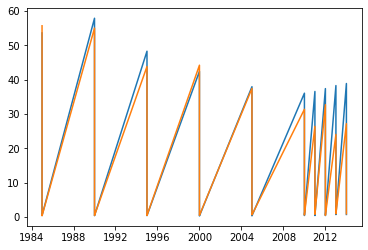

In [548]:
plt.plot(usa['suicides/100k pop'])
plt.plot(argentina['suicides/100k pop'])
plt.plot(bolivia['suicides/100k pop']);

In [407]:
X = ratedf.drop('suicides/100k pop', axis=1)
y = ratedf['suicides/100k pop']

X_train, X_test, y_train, y_tes2 = train_test_split(X, y)
X_scaled = (X_train - np.mean(X_train)) / np.std(X_train)

In [408]:
X_int = sm.add_constant(X_scaled)
mod2 = sm.OLS(y_train, X_int.astype(float)).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      suicides/100k pop   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     242.5
Date:                Wed, 24 Nov 2021   Prob (F-statistic):               0.00
Time:                        13:54:23   Log-Likelihood:                -25299.
No. Observations:                6273   AIC:                         5.063e+04
Df Residuals:                    6257   BIC:                         5.074e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         12.0261      0.173     69.667      0.000      11.688      12.365
suicides_no                    4.7528      0.294     16.157      0.000       4.176       5.329
population                    -3.6468      0.255    -14.284      0.000      -4.147      -3.146
HDI for year                   3.3696      0.279     12.071      0.000       2.822       3.917
gdp_per_capita ($)            -2.4930      0.272     -9.176      0.000      -3.026      -1.960
sex_female                  1.413e+13   7.13e+13      0.198      0.843   -1.26e+14    1.54e+14
sex_male                    1.413e+13   7.13e+13      0.198      0.843   -1.26e+14    1.54e+14
age_15-24 years            -1.619e+14   2.62e+13     -6.190      0.000   -2.13e+14   -1.11e+14
age_25-34 years            -1.622e+14   2.62e+13     -6.190      0.000   -2.14e+14   -1.11e+14
age_35-54 years            -1.609e+14    2.6e+13     -6.190      0.000   -2.12e+14    -1.1e+14
age_5-14 years              -1.62e+14   2.62e+13     -6.190      0.000   -2.13e+14   -1.11e+14
age_55-74 years            -1.618e+14   2.61e+13     -6.190      0.000   -2.13e+14   -1.11e+14
age_75+ years              -1.626e+14   2.63e+13     -6.190      0.000   -2.14e+14   -1.11e+14
generation_Boomers          3.472e+12   3.53e+12      0.984      0.325   -3.44e+12    1.04e+13
generation_G.I. Generation  2.605e+12   2.65e+12      0.984      0.325   -2.58e+12    7.79e+12
generation_Generation X     4.187e+12   4.25e+12      0.984      0.325   -4.15e+12    1.25e+13
generation_Generation Z     2.854e+12    2.9e+12      0.984      0.325   -2.83e+12    8.54e+12
generation_Millenials       4.144e+12   4.21e+12      0.984      0.325   -4.11e+12    1.24e+13
generation_Silent           3.914e+12   3.98e+12      0.984      0.325   -3.88e+12    1.17e+13
==============================================================================
Omnibus:                     3446.420   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38545.977
Skew:                           2.413   Prob(JB):                         0.00
Kurtosis:                      14.144   Cond. No.                     2.32e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.74e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [194]:
X_scaled = (X_train - np.mean(X_train)) / np.std(X_train)
X_int = sm.add_constant(X_scaled)
mod4 = sm.OLS(y_train, X_int).fit()
mod4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Happiness Score   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     384.3
Date:                Wed, 24 Nov 2021   Prob (F-statistic):          1.81e-161
Time:                        11:12:22   Log-Likelihood:                -530.68
No. Observations:                 585   AIC:                             1071.
Df Residuals:                     580   BIC:                             1093.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             5.3462      0.025    214.795      0.000       5.297       5.395
Economy (GDP per Capita)          0.6513      0.033     19.823      0.000       0.587       0.716
Social support                    0.3562      0.031     11.401      0.000       0.295       0.418
Trust (Government Corruption)     0.1612      0.028      5.701      0.000       0.106       0.217
Generosity                        0.1279      0.027      4.772      0.000       0.075       0.181
==============================================================================
Omnibus:                        1.052   Durbin-Watson:                   2.177
Prob(Omnibus):                  0.591   Jarque-Bera (JB):                1.141
Skew:                          -0.092   Prob(JB):                        0.565
Kurtosis:                       2.886   Cond. No.                         2.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [269]:
happydf.set_index(['Year'], inplace=True)

In [525]:
arg = argentina['suicides/100k pop']

In [526]:
naive = arg.shift(1)
naive

Year
1985-01-01      NaN
1985-01-01    55.65
1985-01-01    24.29
1985-01-01    12.37
1985-01-01     9.11
              ...  
2014-01-01     3.77
2014-01-01     3.66
2014-01-01     3.15
2014-01-01     1.89
2014-01-01     0.99
Name: suicides/100k pop, Length: 120, dtype: float64

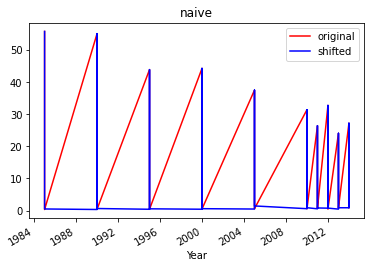

In [560]:
fig, ax = plt.subplots()

arg.plot(ax=ax, c='r', label='original')
naive.plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

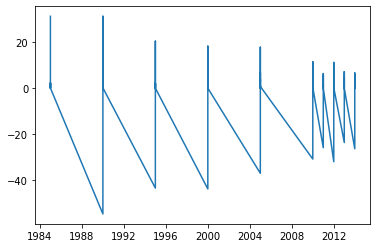

In [561]:
fig, ax = plt.subplots()
residuals = naive[1:] - arg[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(1).std());

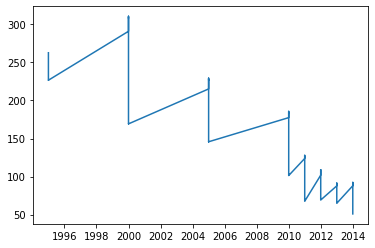

In [530]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

In [551]:
p_val = adfuller(arg.diff()[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 5.822439649331705e-13,
 so we can safely assume that the differenced data is stationary.


In [557]:
ar_1 = ARIMA(arg, order=(1, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

Year
1985-01-01     0.000000
1985-01-01    55.648247
1985-01-01    31.367922
1985-01-01    15.060333
1985-01-01     9.845779
                ...    
2014-01-01     4.277823
2014-01-01     3.684827
2014-01-01     3.265107
2014-01-01     2.174381
2014-01-01     1.193129
Name: predicted_mean, Length: 120, dtype: float64

In [558]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      suicides/100k pop   No. Observations:                  120
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -459.609
Date:                Wed, 24 Nov 2021   AIC                            923.217
Time:                        15:37:23   BIC                            928.776
Sample:                             0   HQIC                           925.474
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2257      0.083     -2.723      0.006      -0.388      -0.063
sigma2       132.4505      7.781     17.021      0.000     117.199     147.702
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):               460.25
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             2.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""